In [1]:
# #testing metapub 

# from metapub import PubMedFetcher
# fetch = PubMedFetcher()

# # get the first 1000 pmids matching "breast neoplasm" keyword search
# pmids = fetch.pmids_for_query('learning health system')

# print('Retrieving abstracts...')

# # get abstract for each article:
# abstracts = []
# for pmid in pmids:
#     abstracts.append(fetch.article_by_pmid(pmid).abstract)
#     print(pmid)
    
# print('Abstract retrieval done.')
# print(abstracts)
    


Here I am testing out an approach to conduct topic modelling on the Learning Health System literature. This is a proof of concept just to wrap my head around approaches or workflows I can try out for the actual mapping review. The motivation of this exercise is to see whether topic modelling is viable, and whether the keywords that surface within each topic feel self-explanatory and interpretable by the investigators. 

Firstly, I downloaded a collection of references from ovid medline with the following search term: "learning health system".mp 
I only downloaded hits from 2010 - Current, as a RIS file. 


I then load and parse the reference data through Rispy, a Ris parser to examine and extract title and abstracts. 
Exceptions that are raised are stored in a separate pandas dataframe for now, and treated as incomplete references. 
Cleaned data is stored in df_cleaned. 

NB: There are ways to download references programatically, and I tested this, for exmaple, the first cell in this document. It's slower and probably less efficient then doing a bulk download in my opinion. Though if we were setting up an entire pipeline to say feed a truly "living guideline or living review", programmatic access to the literature base may be a pre-requisite, but I digress. 


In [2]:
import rispy
import pandas as pd 
data = {'PMID':[000],'Authors': ['John Doe'],'Title': ['Loreum Ipsum'],'Abstract':['Loreum Ipsum']}
df_cleaned = pd.DataFrame(data)
dirtydata = {'Misc row':['na']}
df_dirty = pd.DataFrame(dirtydata)

path = "LHS Keyword.ris"
with open(path, 'r') as reference_file: 
    entries = rispy.load(reference_file)

    for entry in entries:
        try:
#             print(entry['id'],entry['first_authors'])
            new_row = {'PMID':[entry['id']],'Authors':[entry['first_authors']], 'Title':[entry['primary_title']],'Abstract':[entry['notes_abstract']]}
            df_cleaned=df_cleaned.append(new_row,ignore_index=True)
            
            
        except:
#             dealing with exceptions via assigning these into a "dirty" data frame for more wrangling later on. 
            df_dirty = df_dirty.append(entry, ignore_index=True)
            continue
             
    
print(df_cleaned['Abstract'])
#print(df_dirty)
    



0                                           Loreum Ipsum
1      [BACKGROUND: Randomized clinical trials (RCT) ...
2      [PURPOSE: Genetic laboratory test reports can ...
3      [PURPOSE: The availability of genetic test dat...
4      [BACKGROUND AND AIMS: In order to provide high...
                             ...                        
429    [In 2008 a pregnancy registration system was i...
430    [Nurse executives are responsible for a workfo...
431    [Personalized medicine is the future of clinic...
432    [A patient-focused learning health system, usi...
433    [We outline the fundamental properties of a hi...
Name: Abstract, Length: 434, dtype: object


After extracting title and abstracts into the dataframe, I'm aiming to do some phrase detection, to see whether we can pick up things like "multiple sclerosis" as phrases so that later on, we treat these as single terms. 

The gensim package has a number of useful modules to help with this. So first, I use the titles within my data set to train the inbuilt bigram model to pickup 2 word phrases within the title. I then run the model again, to pick up 3 word phrases. 

Upon exmaination of the learned phrases, it seems that we've got a lot of work to do. Though reading the trigrams themselves is quite informative in my opinion. Problems related to this could perhaps be addressed in better selection of stop words, and lemmatisation.  

In [3]:
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS

documents = df_cleaned['Title']
new_title_list = []

for title in documents: 
    raw_title = (str(title).lower())
    new_title_list.append(raw_title)

sentence_stream = [doc.split(" ") for doc in new_title_list]


bigram = Phrases(sentence_stream, min_count=1, threshold=4, connector_words=ENGLISH_CONNECTOR_WORDS)
trigram = Phrases(bigram[sentence_stream], min_count=1, threshold= 10, connector_words=ENGLISH_CONNECTOR_WORDS)

#storing phraser models
bigram_phraser = Phraser(bigram)
trigram_phraser = Phraser(trigram)

#checking learned phrases
trigram_list = []
for three_wphrase in trigram_phraser.phrasegrams.keys():
    trigram_list.append(three_wphrase)
    
bigram_list = []
for two_wphrase in bigram_phraser.phrasegrams.keys():
    bigram_list.append(two_wphrase)

print('2 word Phrase list: ',bigram_list)
print('3 word Phrase list: ',trigram_list)



2 word Phrase list:  ['patients_with_chronic', '["a_qualitative', 'genetic_test', 'qualitative_study', 'data_communication', 'inflammatory_bowel', "bowel_disease.']", 'learning_healthcare', 'healthcare_system:', 'health_system', 'data_sharing', 'health_care', 'spinal_cord', 'cord_injury', "future_directions.']", 'use_among', 'bowel_disease', 'learning_health', "health_system.']", 'system_to_reduce', 'substance_use', 'artificial_intelligence', 'data_warehouse', "translational_research.']", "qualitative_study.']", 'we_need', 'clinical_decision', 'primary_care', 'integrating_research', "primary_care.']", 'research_network', 'data_to_improve', 'big_data', 'data_and_digital', "clinical_research.']", "['learning_health", 'health_systems:', 'real-world_impact', 'mental_health', 'electronic_health', 'health_record', 'intervention_to_improve', 'health_systems', 'community_health', "health_systems.']", 'collaborative_learning', 'health_system."]', 'controlled_trial', 'analysis_of_the_learning', 

Here I then use the phrase detection model I used in the cell above and apply it to the raw abstract data. 

Firstly, I obtain some inbuilt stop words from the ntlk library, and add some sample stop words that are field specific. Don't mind these as they are leftovers from experimentation for now.  I then remove all stop words, and then apply the phrase detection model. This goes through the abstract data, detects phrases, and then appends all pre-procssed data to a final cleaned_texts list.  

In [4]:
#doing some data pre-processing
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

#firstly remove stop words. 
tokenizer = RegexpTokenizer(r'\w+')
en_stop = set(stopwords.words('english'))
extra_stopwords = en_stop.union(["health","data","use","research","learning","healthcare","system","patient",'the','p','background','purpose'])

p_stemmer = PorterStemmer()

cleaned_texts = []

for i in df_cleaned['Abstract']:
    raw = (str(i).lower())
    # clean and tokenize document string
    tokens = tokenizer.tokenize(raw)
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    data_bigram_apply = trigram_phraser[stopped_tokens]
#     stopped_tokens = [i for i in tokens if not i.isdigit()]
    # stem tokens
#     stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    # add tokens to list
    cleaned_texts.append(data_bigram_apply)
    





Here I am prepping my cleaned text data for model traning. I go through the data, and create a dictionary of all unique term or tokens within my data set. I then map this dictionary with my original data set, and convert this into a bag of words  format named doc_term_matrix. 

I then ran a quick check with an LDA model that is inbuilt within gensim for the appropriate number of topics to use for the final topic modelling task. Thus, i iterate from 1 to 20 topics, and check the coherence score for each topic. 

The precise implementation is something I am still leraning to understand at the moment, but for now high coherence score is better, though not always. Some inspection of the topics and the keywords in each will be needed to see whether it is intepretable. 

In [5]:
#preparing corpus 

from gensim import corpora
from gensim.models import ldamodel
from gensim.models.coherencemodel import CoherenceModel

# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(cleaned_texts)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in cleaned_texts]
# generate LDA model

#assessing number of appropriate topics 
coherence_values = []
model_list = []
for number_of_topics in range(1, 20, 1):
    # generate LDA model
    model = ldamodel.LdaModel(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary)  # train model
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=cleaned_texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())



Now, I plot the coherrence score against the number of topics I used. Truthfully, the coherence score is low, with a topic of 1 being the highest, which is to be expected. 

Topic numbers of 2, 4, 6 seem to be usable, so I will use this for the final topic modelling task. 
I am using LDA - primarily becasue tehre is a nifty python package that runs the entire visualisation pipeline in 1 line. The conssequence for which I am still studying. But! We're experimenting so let's see what we get and whether the results are intepretable. 

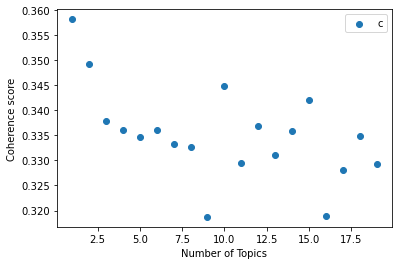

In [6]:
import matplotlib.pyplot as plt

x = range(1, 20, 1)
plt.scatter(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Running the LDA model with 4 topics. Each token or word has an associated frequency in decimals, hence this is the weighting of the term in each topic. 

In [8]:
from gensim.models import ldamodel

number_of_topics=4
words = 10


ldamodel = ldamodel.LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))

import pyLDAvis.gensim_models
import pyLDAvis


print('preparing')
ref_vis_data = pyLDAvis.gensim_models.prepare(ldamodel,doc_term_matrix,dictionary)
print('done')
pyLDAvis.display(ref_vis_data)


[(0, '0.016*"data" + 0.012*"system" + 0.008*"research" + 0.008*"learning_health" + 0.007*"care" + 0.006*"patients" + 0.006*"patient" + 0.006*"health" + 0.006*"lhs" + 0.006*"systems"'), (1, '0.010*"data" + 0.007*"systems" + 0.007*"learning_health" + 0.007*"system" + 0.007*"research" + 0.006*"clinical" + 0.005*"health" + 0.005*"care" + 0.005*"use" + 0.004*"0"'), (2, '0.019*"data" + 0.008*"system" + 0.007*"care" + 0.007*"learning_health" + 0.007*"research" + 0.006*"clinical" + 0.006*"health" + 0.005*"patient" + 0.005*"systems" + 0.004*"lhs"'), (3, '0.013*"research" + 0.009*"patient" + 0.008*"data" + 0.008*"care" + 0.008*"patients" + 0.008*"health" + 0.006*"clinical" + 0.006*"learning_health" + 0.005*"systems" + 0.004*"outcomes"')]
preparing
done


Above is the final visualisation, giving you an overview of the topics within the dataset. The precise implementation needs to be looked into (homework for me) but the spacings seem to indicate that the topics are relatively well defined. This is an interactive visualisation so you can adjust and mouseover the bubbles to see the terms contained within. At first glance, it is obvious that we've got a lot of refining to do. But this is a relatively dirty proof of concept. Hopefully this sparks discussion on where to next.

I'll still keep refining in the mean time. It may be worth removing repeated terms across topics like "data" and doing more in the pre-procesisng stage to tune this appropriately. Another thing to do is implementing some form of lemmatisation. 

Another idea at this point is the apply a medical ontology dataset or vocab to this abstract, and model the topics BASED on the medical annotations. To do this, I will need to take a closer look at the MEDCAT documentation from the folks over at KIng's College London. However this may be a better approach. Will report back. 